### Solving for a private mean age of a population

To solve for a private mean age of a population, we first:
1. get an estimate of the total age (by adding Laplace noise)
2. get an estimate of the total population (by adding Laplace noise)
3. divide the two estimates

We can do this with the *dp_mean* method below, which also calls *laplace_mech*.

In [ ]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

def dp_mean(eps_n, eps_d, top, bot, top_sen=100.0, bot_sen=1.0):
  noisy_top = laplace_mech(top, eps_n, top_sen)
  noisy_bot = laplace_mech(bot, eps_d, bot_sen)
  return noisy_top / noisy_bot

def mse(true_answer, function_name, *params):
  """true_answer is either a scalar or numpy array"""
  niterations = 100_000
  return sum(np.sum((true_answer - function_name(*params))**2) for x in range(niterations)) / float(niterations)

Let's start by import the necessary libraries and loading the PUMS data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pa = pd.read_csv("psam_p42.csv")

Next, let's query the population we want to calculate the mean age of.

In [ ]:
asn_pa = pa.query('RACASN==1 and PUMA==1000')

Now, let's calculate the values we need for *dp_mean*. These inclue *total_age*, *total_population*, *age_sensitivity*, and *population_sensitivity*.

In [13]:
# TODO: clarify sensitivities here
total_age = asn_pa.AGEP.sum()
total_population = float(asn_pa.AGEP.size)
age_sensitivity = asn_pa.AGEP.max()/2
population_sensitivity = 1.0

We also need to consider our privacy budget, *eps*. We can take *eps* and split it into two pieces: one for estimating the numerator (*eps_n*) and another for estimating the denominator (*eps_d*), so that *eps = eps_n + eps_d*.

The choice of *eps_n* and *eps_d* clearly affects accuracy. Plug in 
different values for *eps_n* and *eps_d* to see how low you can make 
the estimated mse. 

In [14]:
eps_n = 0.5 
eps_d = 0.5
assert eps_n + eps_d <= 1.0000000001, "eps_n + eps_d must be at most 1"

We can test these values and their accuracy with the *dp_mean* and *mse* functions, like below.

In [ ]:
noisy_mean = dp_mean(eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)
error = mse(total_age/total_population, dp_mean, eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)
print("a noisy mean is ", noisy_mean)
print("mse is ", error)

We want to be able to calculate the *noisy_mean* for different values of epsilon and calculate the average accuracy of the *noisy_mean* for each of these epsilons, so that we can compare the accuracy-privacy trade off. The function below does this using L1 norm as the accuracy measure.

In [11]:
def avg_l1_mean(true_mean, eps, n=1000):
    total = 0
    for i in range(n):
        noisy_mean = dp_mean(eps/2, eps/2, total_age, total_population, age_sensitivity, population_sensitivity)
        accuracy = 1 - (np.linalg.norm([noisy_mean-true_mean], 1)/(2*1))
        total += accuracy
    return total/n

Let's use *avg_l1_mean* to calculate the average accuracy of the noisy mean over a range of epsilon values and visualize the output.

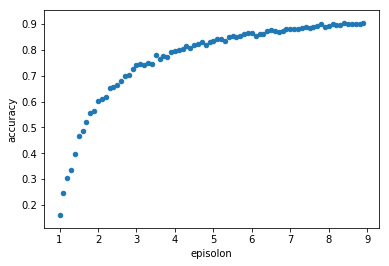

In [12]:
accuracy_df = pd.DataFrame()
eps_range = (np.arange(1.0,9.0,.1))
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_mean(total_age/total_population, x) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()